# **Создаем Модель Распознования Именованных Сущностей**

## <b><span style='color:#686dec'>Введение</span></b>

### **`NER` отзывов автомобилей**

В этом ноутбуке мы продолжим тему задачу распознавания именованных сущностей `NER`
- Мы будем использовать размеченные данные отзвов автомобилей, сохраненные в удобном формате `xml`.
- В прошлом ноутбуке мы пользовались готовым инструменами для `NER`. 
- В данном ноутбуке мы будем обучать свою собственную `NER` модель (GRU) которую будем использовать для распознования именованных сущностей по темам связанным с автомобилями
- У нас две разметки `sentiment` и `category`, но для текущей задачи NER, воспользуемся меткой <code>category</code>

### **Импортируем библиотеки**



In [69]:
pip install ipymarkup pymorphy2 livelossplot

Note: you may need to restart the kernel to use updated packages.


In [70]:
import os
import sys
from tqdm import tqdm
import typing
from functools import lru_cache
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from livelossplot import PlotLosses

import random
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

## <b><span style='color:#686dec'>PIPELINE: Загрузка данных</span></b>

### **Чтение `XML` данных**

Используем вспомогательные функции из библиотеки `dlnlputils` из github

- Для чтения `xml` данных воспользуемя библиотекой `lxml`
- `ipymarkup` из библиотеки `natasha` используем для визуализации

In [71]:
import lxml
from lxml import etree

# get spans in xml for <category>
def get_aspect_spans(root):
    return get_tag_spans(root,'category')

# get the start & ending in <text>
def get_tag_spans(root,tag):
    attributes = root.attrib
    start = int(attributes['from'])
    end   = int(attributes['to'])
    tag   = attributes[tag]
    span  = (start,end,tag)
    return span

def parse_xml_aspect(xml_file):
    return parseXML(xml_file,
                    get_aspect_spans)

# helper; parse XML & get marked spans in <text>
# span_func : parse_xml_aspect

def parseXML(xmlFile, span_func):

    xml  = open(xmlFile).read()
    root = etree.fromstring(xml)

    result = []
    for review in root.getchildren():
        for elem in review.getchildren():
            if elem.tag == 'text':
                text  = elem.text
            if elem.tag == 'aspects':
                spans = [span_func(xml_span) for xml_span in elem.getchildren()]
                spans = span_sanity_filter(spans)
        result.append((text, spans))
    return result

def span_sanity_filter(spans):
    result = [spans[0]]

    for span in spans[1:]:
        _,prev_span_end,_   = result[-1]
        curr_span_start,_,_ = span

        if prev_span_end < curr_span_start:
            result.append(span)
    return result

In [72]:
# show tags from natasha library
from ipymarkup         import show_box_markup
from ipymarkup.palette import palette, PALETTE, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

# aspect
PALETTE.set('Comfort',ORANGE)
PALETTE.set('B-Comfort',ORANGE)
PALETTE.set('I-Comfort',ORANGE)
PALETTE.set('Appearance',BLUE)
PALETTE.set('B-Appearance',BLUE)
PALETTE.set('I-Appearance',BLUE)
PALETTE.set('Reliability',GREEN)
PALETTE.set('B-Reliability',GREEN)
PALETTE.set('I-Reliability',GREEN)
PALETTE.set('Safety',PURPLE)
PALETTE.set('B-Safety',PURPLE)
PALETTE.set('I-Safety',PURPLE)
PALETTE.set('Driveability',BLUE)
PALETTE.set('B-Driveability',BLUE)
PALETTE.set('I-Driveability',BLUE)
PALETTE.set('Whole',RED)
PALETTE.set('B-Whole',RED)
PALETTE.set('I-Whole',RED)
PALETTE.set('Costs',RED)
PALETTE.set('B-Costs',RED)
PALETTE.set('I-Costs',RED)

def show_markup(text,spans):
    show_box_markup(text, spans, palette=PALETTE)

### **Парсим `XML`**

- Документы с разметкой аспектов парсим с помощью `parse_xml_aspec`
- На выходе получаем список кортежов докуменов в `xml` (текст и разметки)


In [73]:
xml = 'SentiRuEval_car_markup_train.xml'
texts_w_aspect_spans    = parse_xml_aspect('/kaggle/input/araneum/'+xml)

amount = len(texts_w_aspect_spans)
print('Загружено {} текстов с разметкой\n'.format(amount))

Загружено 217 текстов с разметкой



In [74]:
texts_w_aspect_spans[0]

('Недавно купил этот автомобиль. Авто отличное! Двигатель 2,5 литра, турбодизель. Прежний хозяин сказал при продаже, что масло не жрет, солярку тоже, летит как угорелая! Так оно и есть. 140 км/ч нормальная крейсерская скорость. Вообще немцы умеют делать автомобили. Дорогу держит отлично, так как достаточно широкая машина. Тормоза все дисковые. Главное передний привод, по сравнению с другими немецкими автомобилями. Такими как мерседес и бмв этого же класса. Места в автомобиле очень много. Не тесно даже, когда сидят пять взрослых человек. Багажное отделение тоже огромно. Влезла стиральная машина. По соотношению цена - качество, отличный автомобиль. Больше никогда не сяду за руль российского автомбиля! Всем рекомендую Ауди. ',
 [(19, 29, 'Whole'),
  (31, 35, 'Whole'),
  (46, 65, 'Driveability'),
  (67, 78, 'Driveability'),
  (125, 132, 'Driveability'),
  (134, 141, 'Driveability'),
  (148, 166, 'Driveability'),
  (204, 224, 'Driveability'),
  (252, 262, 'Whole'),
  (264, 277, 'Driveabilit

##### Выберем текст, на котором будем проверять preprocessing pipeline

In [75]:
random_picks = [random.randint(0,amount-1) for _ in range(0,1)]
random_picks

[195]

### **Разметка для NER**

Тэги которые мы будем использовать для создания NER - aspect

In [76]:
text,spans = texts_w_aspect_spans[random_picks[0]]
show_markup(text,spans)

## <b><span style='color:#686dec'>PIPELINE: BIO-тэги</span></b>

- Для обучения модели будем использовать **BIO** тэговую систему разметки, ie. `beginner`, `inner` и `outer`
- По началу отметим то что является тэгом "все прочие", создадим span для все что не было размеченным с пмощью `fill_gaps`

In [77]:
"""

Заполняем пробелы в авторской разметке

"""

def fill_gaps(text, source_spans):

    chunks = []
    text_pos = 0
    for span in source_spans:
        s,e,t = span
        if text_pos<s:
            chunks.append((text_pos,s,'Other'))
        chunks.append((s,e,t))
        text_pos=e

    if text_pos<len(text)-1:
        chunks.append((text_pos,len(text),'Other'))

    return chunks

"""

Разобьем на bio-токены по безпробельной разметке

"""

def extract_BIO_tagged_tokens(text, source_spans, tokenizer):

    tokens_w_tags = []
    for span in source_spans:
        s,e,tag  = span
        tokens   = tokenizer(text[s:e])

        if tag == 'Other':
            tokens_w_tags += [(token,tag) for token in tokens]
        else:
            tokens_w_tags.append((tokens[0],'B-'+tag))
            for token in tokens[1:]:
                tokens_w_tags.append((token,'I-'+tag))

    return tokens_w_tags

In [78]:
text, aspect_spans = texts_w_aspect_spans[random_picks[0]]
cover_spans       = fill_gaps(text, aspect_spans)

print('\nПолное покрытие разметкой текста :','\n')
show_markup(text, cover_spans)


Полное покрытие разметкой текста : 



## <b><span style='color:#686dec'>Pipeline: Разбиение на предложение</span></b>

### **Разбиение на предложение**

- Для модели нам нужно немного переделать разметку (spans)
- Разбиение документа на предложения, а предложений - на слова.

In [79]:
# регулярка по которой мы разбиваем 
def regex_sentence_detector(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return sentences

"""

Разбиваем на предложения и генерируем разметку - для красоты

"""

def sentence_spans(text, sentence_detector):

    sentences = sentence_detector(text)
    spans = []

    sent_start= 0
    idx       = 1
    for sent in sentences:
        sent_end = sent_start + len(sent)
        spans.append((sent_start,sent_end, 's{}'.format(idx)))

        sent_start = 1+sent_end
        idx       += 1

    return spans


"""

Разбиваем на предложения и перегенерируем разметку

"""

def sentence_splitter(text, spans):
    result = []
    sentences = regex_sentence_detector(text)

    sent_start = 0
    span_idx   = 0

    for sent in sentences:
        sent_end = sent_start + len(sent)

        sent_spans = []
        for span in spans[span_idx:]:
            s,e,t = span
            if e <= sent_end:
                sent_spans.append((s-sent_start,e-sent_start,t))
                span_idx+=1
            else:
                continue

        result.append((text[sent_start:sent_end], sent_spans))

        sent_start = 1+sent_end

    return result


### **Определимся с токенизатором**

Определимся с токенизатором, для токенизатора возмем `RegexpTokenizer`

In [80]:
from nltk.tokenize import RegexpTokenizer
word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

### **Группируем все компонены pipeline**

На одном примере проверим весь пайплаин:
- Разбиваем документ на предложение <code>sentence_splitter</code>
- Создаем прочие тэги <code>fill_gaps</code>
- Создаем общие BIO тэги (метки для классификации)

In [81]:
text, aspect_spans = texts_w_aspect_spans[random_picks[0]]
print('Разбиение на предложения и BIO токенизация текста') 
for sentence, spans in sentence_splitter(text, aspect_spans):

    cover_spans      = fill_gaps(sentence,spans)
    tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

    show_markup(sentence, cover_spans)
    print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста


[('О', 'Other'), ('плюсах', 'Other'), ('автомобиля', 'B-Whole')] 



[('Доступные', 'Other'), ('запчасти', 'B-Reliability'), (',', 'Other'), ('можно', 'Other'), ('найти', 'Other'), ('в', 'Other'), ('любом', 'Other'), ('городе', 'Other'), (',', 'Other'), ('в', 'Other')] 



[('Машина', 'B-Driveability'), ('хорошая', 'Other'), (',', 'Other'), ('только', 'Other'), ('на', 'Other'), ('дальнюю', 'Other'), ('дорогу', 'Other'), (',', 'Other'), ('бензин', 'Other'), ('на', 'Other')] 



[('Хорошая', 'Other'), ('подвеска', 'B-Driveability'), ('и', 'Other'), ('высокий', 'B-Driveability'), ('клиренс', 'I-Driveability')] 



[('В', 'B-Reliability'), ('обслуживании', 'I-Reliability'), ('неприхотлив', 'B-Reliability')] 



[('Слабый', 'B-Driveability'), ('двигатель', 'I-Driveability'), (',', 'Other'), ('не', 'Other'), ('тянет', 'Other'), ('больше', 'Other'), ('3000', 'Other'), ('оборотов', 'Other'), (',', 'Other'), ('очень', 'Other')] 



[('Плохо', 'Other'), ('расставлены', 'Other'), ('коэффициенты', 'B-Driveability'), ('в', 'I-Driveability'), ('коробке', 'I-Driveability'), ('передач', 'I-Driveability')] 



[('Очень', 'Other'), ('слабая', 'Other'), ('рулевая', 'B-Reliability'), ('рейка', 'I-Reliability'), (',', 'Other'), ('требует', 'B-Reliability'), ('постоянного', 'I-Reliability'), ('ремонта', 'I-Reliability'), ('после', 'Other'), ('каждой', 'Other')] 



[('Очень', 'Other'), ('плохой', 'Other'), ('металл', 'B-Reliability'), (',', 'Other'), ('ржавеет', 'B-Reliability'), ('моментально', 'Other'), ('.', 'Other')] 



[('Плохая', 'Other'), ('шумоизоляция', 'B-Comfort')] 



[('Подойдет', 'Other'), ('как', 'Other'), ('первая', 'Other'), ('машина', 'B-Whole'), (',', 'Other'), ('сам', 'Other'), ('сломал', 'Other'), ('сам', 'Other'), ('починил', 'Other'), ('.', 'Other')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('Дешевый', 'B-Costs'), (',', 'Other'), ('неприхотливый', 'B-Reliability'), (',', 'Other'), ('низкий', 'B-Driveability'), ('расход', 'I-Driveability'), ('топлива', 'I-Driveability')] 




## <b><span style='color:#686dec'>Используем pipeline</span></b>

### **Готовый pipeline**

Теперь пройдем через всю предобработку на обучающей и тестовой выборки

Пайплаин предобработки `xml` тексовых данных для NER:
- `parse_xml_aspect` - парсим `xml` и сохраняем кордежы текста и меток в тексте
- `sentence_splitter` - разбиваем документ на предложении и обновляем расположение меток
- `fill_gaps` - создаем метки для всех остальных токенов 
- `extract_BIO_tagged_tokens` - создаем BIO тэги для токенов

In [82]:
def form_vocabulary_and_tagset(words_w_tags):
    
    dictionary = set()
    tagset     = set()

    for words,tags in words_w_tags:
        for word, tag in zip(words, tags):
            dictionary.add(word)
            tagset.add(tag)

    return dictionary,tagset


# create (token,tag) data
def prepare_data(texts_with_spans, tokenize_func):
    
    result = []
    for text, spans in texts_with_spans:
        for sent, sent_spans in sentence_splitter(text, spans):
            if len(sent)>1:
                cover_spans      = fill_gaps(sent, sent_spans)
                try:
                    tokens_w_biotags = extract_BIO_tagged_tokens(sent, cover_spans, tokenize_func)
                    tokens, biotags  = list(zip(*tokens_w_biotags))
                    result.append((tokens, biotags))

                except Exception as e:
                    continue

    return result

### **Загружаем данные**

Загружаем оюучающию и тестовые данные в готорый пайплаин и получаем списки токенов и ее метка

In [83]:
xml_train = 'SentiRuEval_car_markup_train.xml'
xml_test  = 'SentiRuEval_car_markup_test.xml'

texts_w_aspect_spans = parse_xml_aspect('/kaggle/input/araneum/'+xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect('/kaggle/input/araneum/'+xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [84]:
texts_w_aspect_spans[0]

('В принципе машинка не плохая, объемом в 2.0 куба, легкий кузов, дорогу держит не плохо, приятна по салону, сделана в спорт стиле, по городу 9 литров не больше, по трассе 7, но есть и минусы что по ходовой слабенькая машина и кузова почти у всех гниют со временем, многие водители этого не замечают, не говорю что все 100% гниют. Общее впечатление : Слабая по ходовке,цветет кузов.',
 [(11, 18, 'Whole'),
  (57, 62, 'Driveability'),
  (64, 77, 'Driveability'),
  (99, 105, 'Appearance'),
  (115, 128, 'Appearance'),
  (130, 139, 'Driveability'),
  (160, 169, 'Driveability'),
  (197, 204, 'Driveability'),
  (216, 222, 'Driveability'),
  (225, 231, 'Reliability'),
  (245, 250, 'Reliability'),
  (322, 327, 'Reliability'),
  (359, 366, 'Driveability'),
  (367, 373, 'Reliability'),
  (374, 379, 'Reliability')])

In [85]:
training_data[0]

(('Недавно', 'купил', 'этот', 'автомобиль'),
 ('Other', 'Other', 'Other', 'B-Whole'))

Разбиение на предложения дало нам столько коротких текстов


In [86]:
len(training_data), len(test_data)

(2210, 1922)

### **Словарь и Метка**

Словарь содержащий все токены (слова) в выборках и все метки

In [87]:
all_data = training_data + test_data
vocabulary, labels = form_vocabulary_and_tagset(all_data)

In [88]:
labels = sorted(labels)
labels

['B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other']

In [89]:
len(vocabulary), len(labels)

(11333, 15)

## <b><span style='color:#686dec'>Pipeline: Embedding</span></b>

###  **Загружаем fasttext вектора**

- Воспользуемся предобученными векторными представлениями слов модели (araneum_none_fasttextcbow_300_5_2018)
- Алгоритм fasttext обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [92]:
import gensim
import urllib.request
import zipfile

# название и URL
we_models = {"geowac_lemmas_none_fasttextskipgram_300_5_2020": "http://vectors.nlpl.eu/repository/20/213.zip",}

In [93]:
# сохраняем модель
def get_models(model_url, model_name, path_to_save="/kaggle/working/"):
    model_path = path_to_save + model_name + ".zip"
    urllib.request.urlretrieve(model_url, model_path)

for model_name, model_url in we_models.items():
    get_models(model_url, model_name)

In [94]:
# разархивирем 
with zipfile.ZipFile("/kaggle/working/geowac_lemmas_none_fasttextskipgram_300_5_2020.zip", 'r') as zip_ref: 
    zip_ref.extractall("/kaggle/working/geowac_lemmas_none_fasttextskipgram_300_5_2020")
    
# загружаем KeyedVectors эмбеддинговый вектора 
# Функция для чтения word2vec / FastText

def open_model(model_name,model_path, is_fasttext = True):
    
    # word2vec (model.bin)
    if is_fasttext == False:
        model_file = model_path + model_name + ".zip"
        with zipfile.ZipFile(model_file, 'r') as archive:
            stream = archive.open('model.bin')
            model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
            
    # fasttext (model.model)
    else:
        model_file = model_path + model_name
        model = gensim.models.KeyedVectors.load(model_file + "/model.model")
    return model

w2v_model = open_model('geowac_lemmas_none_fasttextskipgram_300_5_2020','/kaggle/working/')

Посмотрим на качество векторов

In [95]:
words = ['тачка', 'двигатель', 'ауди']

for word in words:
    
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')

    #else: print(word + ' is not present in the model')

машина 0.5936635732650757
машинка 0.58965665102005
черепашка 0.5865190029144287
грузовичок 0.5823847055435181
грузовичка 0.5814732909202576
трактор 0.578829824924469
машына 0.5752986073493958
мотороллер 0.5746884942054749
байк 0.574382483959198
автомобильчик 0.5617275238037109


мотор 0.8536396622657776
турбодвигатель 0.7599603533744812
электродвигатель 0.7526513338088989
двс 0.7494674921035767
турбина 0.744778037071228
четырехтактный 0.7394916415214539
карбюраторный 0.7300528883934021
бензиновый 0.7256711721420288
трансмиссия 0.7220973968505859
одноцилиндровый 0.7176888585090637


bmw 0.778282105922699
skoda 0.7711601853370667
citroen 0.7693266272544861
volkswagen 0.7655405402183533
sportback 0.7623247504234314
opel 0.759402334690094
mercedes 0.7484782934188843
vw 0.7478039860725403
q7 0.7471405863761902
passat 0.7310269474983215




###  **Выгрузка векторов**

Вгружаем вектор для данного токена, если его нет в словаре, проходим по содержанию токена и выгружаем н-граммовые вектора и их усредняем

In [97]:
# Выгружаем вектора

def get_vector(w):
    try:
        return w2v_model[w]
    except:
        
        x = np.zeros(300)
        elems = {}
        c = 0
        for i in w2v_model.index2word:
            
            # если часть токена найдена в vocab
            if i in w:
                elems[i] = w2v_model[i]
                c += 1
                
        if c > 0:
            vect = sum(elems.values())
        else:
            return x  # если вообще ничего не найдено
         
        # нормализируем вектора
        n_vect = np.linalg.norm(vect)
        if n_vect < 0.05:
            return np.zeros(300)
        else:
            return vect / n_vect

In [99]:
@lru_cache(10000)
def lemmatize(s):
    s = str(s).lower()
    return morph.parse(s)[0].normal_form

In [100]:
def vectorize_word_seq(word_seq: typing.Iterable[str]):
    vects = []
    for w in word_seq:
        w_l = lemmatize(w)
        vects.append(get_vector(w_l))

    return torch.tensor(np.vstack(vects), requires_grad=False, dtype=torch.float32)

Протестируем вспомогательную функцию которю будем подавать в модель

In [138]:
test = vectorize_word_seq('мама мыла раму'.split())
test.size()

torch.Size([3, 300])

## <b><span style='color:#686dec'>Моделирование</span></b>

###  **Определяем NER модель**

Определяем NER модель и протестируем чтобы убедится что все работает

In [102]:
class RecTagger(nn.Module):

    def __init__(self, embedding_dim, 
                 hidden_dim, 
                 tagset_size, 
                 rec_lalers=1, 
                 labels=None):
        
        super(RecTagger, self).__init__()
        assert labels

        self.labels = sorted(labels)

        self.labels_to_id = {l: i for i, l in zip(range(len(self.labels)), self.labels)}

        self.target_size     = tagset_size
        self.hidden_dim      = hidden_dim

        self.rec             = nn.GRU(embedding_dim, hidden_dim, rec_lalers,
                                      bidirectional=True, batch_first=True)

        self.vect_projection = nn.Linear(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(3*hidden_dim, tagset_size)

    def forward(self, words_seq, device=None):
        
        if device:
            embeds = vectorize_word_seq(words_seq).to(device)
        else:
            embeds = vectorize_word_seq(words_seq)
            
        rec_out, _ = self.rec(embeds)
        vect_proj = self.vect_projection(embeds)
        
        concat_vect = torch.concat([rec_out, vect_proj], dim=-1)
        tag_space   = self.hidden2tag(concat_vect)
        tag_scores  = F.log_softmax(tag_space, dim=-1)

        return tag_scores

    def encode_lebels(self, labels_seq, device=None):
        res = []
        for l in labels_seq:
            res.append(self.labels_to_id[l])
        if device:
            return torch.tensor(res, requires_grad=False).to(device)
        else:
            return torch.tensor(res, requires_grad=False)

    def decode_labels(self, labels_id: np.array):
        res = []
        for i in list(labels_id):
            res.append(self.labels[i])
        return res

    def predict_tags(self, words_seq):
        with torch.no_grad():
            tags_pred = self.forward(words_seq).numpy()
            tags_pred = np.argmax(tags_pred, axis=-1)

        return tags_pred

In [105]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 12
TAGSET_SIZE = len(labels)

# Инициализируем модель (тест)
m_test = RecTagger(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   TAGSET_SIZE, 
                   1, 
                   labels)

In [107]:
# Все разметки
m_test.labels

['B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other']

Проверим количество параметров

In [139]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(m_test)

26775

Убедимся что все работает

In [149]:
# тэровые логарифмический softmax
pred = m_test('мама мыла раму на ауди q5, которая хорошо рулится'.split())
pred

tensor([[-2.7464, -2.8194, -2.9020, -2.6654, -2.6564, -2.5888, -2.4695, -2.6416,
         -2.8311, -2.5134, -2.6439, -2.7907, -2.6945, -2.8152, -2.9826],
        [-2.6151, -2.7963, -3.0382, -2.6598, -2.6631, -2.6316, -2.3924, -2.3449,
         -2.7286, -2.9495, -2.7651, -2.7599, -2.8032, -2.7408, -2.9980],
        [-2.6639, -2.7700, -2.9969, -2.7356, -2.4825, -2.7246, -2.4907, -2.4942,
         -2.9998, -2.7316, -2.5690, -2.7424, -2.5333, -2.8730, -3.0690],
        [-2.7045, -2.8588, -2.8543, -2.7703, -2.4608, -2.7426, -2.4342, -2.6316,
         -2.9949, -2.5709, -2.5761, -2.8725, -2.5081, -2.9079, -2.9766],
        [-2.6249, -2.9957, -3.0788, -2.5937, -2.3531, -2.6346, -2.6320, -2.6055,
         -2.9043, -2.7025, -2.4937, -2.8921, -2.5229, -2.9110, -3.0031],
        [-2.7078, -3.0814, -3.0198, -2.8580, -2.5065, -2.4220, -2.4222, -2.7285,
         -3.0709, -2.6330, -2.4823, -2.7425, -2.4711, -3.0152, -2.8621],
        [-2.6051, -2.8346, -3.0058, -2.8829, -2.6562, -2.5346, -2.4479, -2.7

In [151]:
pred = m_test.predict_tags('мама мыла раму на ауди q5, которая хорошо рулится'.split())

In [152]:
m_test.decode_labels(pred)

['B-Whole',
 'I-Appearance',
 'B-Reliability',
 'B-Whole',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'B-Safety',
 'I-Safety']

In [153]:
m_test.encode_lebels(['I-Reliability', 'I-Whole'])

tensor([11, 13])

### **Взвешеная функция потерь**

- В задачи NER у нас появляется естественные дисбаланс классов (н нас появляются очень много класса `other`)
- Мы можем воспользоватся корректировачными весами для каждого класса, в данном случае веса условно являются обратно пропорциональны частоте в датасете и их передадим в критерию оценки модели `loss_function`

In [114]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1

tag_counter.most_common()

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [166]:
sum((e[1] for e in tag_counter.items()))

30585

In [168]:
class_weights = torch.ones(len(labels))
class_divs    = torch.ones(len(labels))

for tag, inv_weight in tag_counter.most_common():    
    tag_idx             = m_test.labels_to_id[tag]
    class_divs[tag_idx] = inv_weight  # division value

# normalise division value
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))

# calculate class weights
class_weights /= class_divs

print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


### **Инициализируем Модель**

Инициализируем модель, для оценки качества используем `NNLLoss` и потимизатор `SGD`

In [118]:
device = torch.device('cpu')

model         = RecTagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE, 1, labels)
model.to(device)

loss_function = nn.NLLLoss(class_weights).to(device)
optimizer     = optim.SGD(model.parameters(), lr=0.1)

Уберем последовательность предложении 

In [121]:
shuffled = list(range(len(training_data)))
random.shuffle(shuffled)
shuffled[:10]

[1903, 1202, 1833, 933, 224, 1747, 2126, 551, 43, 978]

In [122]:
print(training_data[0][0])
print(training_data[0][1])

('Недавно', 'купил', 'этот', 'автомобиль')
('Other', 'Other', 'Other', 'B-Whole')


### **Обучаем модель**

Обучаем модель на 10 итерации данных

In [170]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (5, 3)

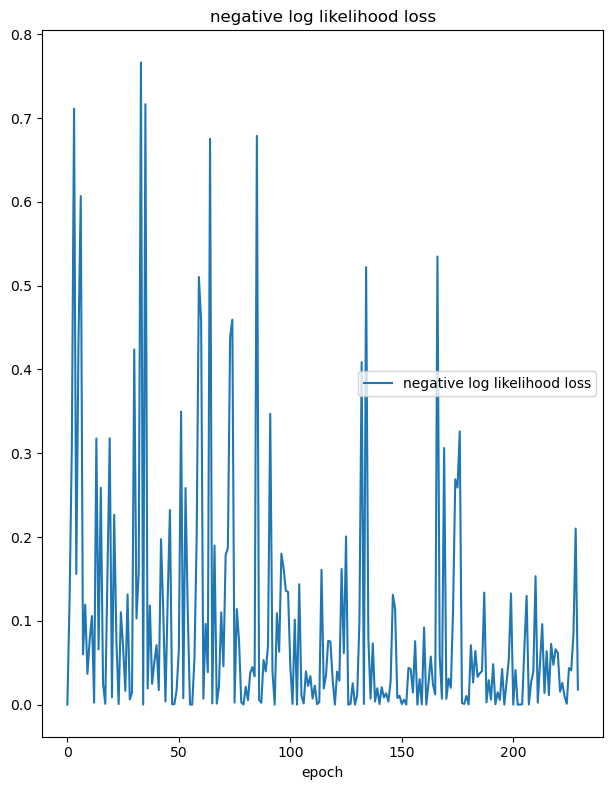

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.000, max:    0.766, cur:    0.018)
CPU times: user 7min 45s, sys: 1min 2s, total: 8min 48s
Wall time: 4min 22s


In [174]:
%%time

liveplot = PlotLosses()

for epoch in range(10): 
    
    shuffled = list(range(len(training_data)))
    random.shuffle(shuffled)
    losses = []
    for i, ind in enumerate(shuffled):
        
        # preprocessing
        words_seq = training_data[ind][0]
        labels_seq = training_data[ind][1]
        labels_tensor = model.encode_lebels(labels_seq, device)
        
        model.zero_grad()
        
        tag_scores = model(words_seq, device)
        loss = loss_function(tag_scores, labels_tensor)
        
        loss.backward()
        optimizer.step()
        
        loss_copy = loss.detach().to('cpu')
        losses.append(loss_copy.item())
        
        
        if(i % 100 == 0):
            liveplot.update({'negative log likelihood loss': loss_copy})
            liveplot.draw()


In [175]:
sum(losses) / len(losses)

0.061214469474302924

### **Проверяем обобщающию способность**

Проверяем средний loss по batch на тестовой выборке

In [154]:
%%time

test_losses = []
with torch.no_grad():
    for ind in range(len(test_data)):
        words_seq = test_data[ind][0]
        labels_seq = test_data[ind][1]

        labels_tensor = model.encode_lebels(labels_seq, device)

        tag_scores = model(words_seq, device)
        loss = loss_function(tag_scores, labels_tensor)

        loss_copy = loss.detach().to('cpu')
        test_losses.append(loss_copy.item())
        
sum(test_losses) / len(test_losses)

CPU times: user 5.85 s, sys: 7.75 ms, total: 5.86 s
Wall time: 2.93 s


1.152625141903092

### **Сохраняем Модель**

Сохраняем модель и тестируем как она работает на новых данных

In [128]:
model.to('cpu')
torch.save(model.state_dict(), './model1.pth')

## <b><span style='color:#686dec'>Тестируем NER тэгера</span></b>

### **Тестируем Модель**

Сохраняем модель и тестируем NER как она работает на новых данных

In [129]:
model1 = RecTagger(EMBEDDING_DIM, 
                   HIDDEN_DIM, TAGSET_SIZE, 
                   1, 
                   labels)

model1.load_state_dict(torch.load('./model1.pth'))
model1.eval()

RecTagger(
  (rec): GRU(300, 12, batch_first=True, bidirectional=True)
  (vect_projection): Linear(in_features=300, out_features=12, bias=True)
  (hidden2tag): Linear(in_features=36, out_features=15, bias=True)
)

In [130]:
# предсказываем тэги и их декодируем
def predict_tags(model, words_seq):
    with torch.no_grad():
        tags = model.predict_tags(words_seq)

    return model.decode_labels(tags)

In [134]:
def generate_markup(tokens,tags):
    
    mapper = lambda tag: tag[2:] if tag!='Other' else tag
    tags  = [mapper(tag) for tag in tags]
    text  = ' '.join(tokens)
    spans = []

    start,end,tag = 0,len(tokens[0]),tags[0]

    for word, ttag in zip(tokens[1:], tags[1:]):

        if tag == ttag:
            end  += 1+len(word)

        else:
            span  = (start, end, tag)
            spans.append(span)

            start = 1+end
            end  += 1+len(word)
            tag   = ttag

    span  = (start, end, tag)
    spans.append(span)

    return text, spans

In [158]:
test_text, test_tags = training_data[1211]
text, spans = generate_markup(test_text, test_tags)
show_markup(text, spans)

In [181]:
for i,j in zip(test_text,test_tags):
    print(i,j)

За Other
первых Other
три Other
года Other
не Other
было Other
ни B-Reliability
одной I-Reliability
поломки I-Reliability
, Other
потом Other
стали Other
проявляться Other
мелкие Other
неисправности B-Reliability
: Other
подшипник B-Reliability
на I-Reliability
полуоси I-Reliability
, Other
лампочки B-Reliability
дальнего I-Reliability
ближнего I-Reliability
света I-Reliability
, Other
крестовины B-Reliability
, Other
аккумулятор B-Reliability
, Other
свечи B-Reliability


In [178]:
for i in range(0,3):
    
    print(f'Пример {i}')

    recipe, tags = test_data[np.random.randint(0,1000)]

    tags_pred    = predict_tags(model1, recipe)

    print('\nистинные тэги:')
    text, spans = generate_markup(recipe, tags)
    show_markup(text, spans)

    print('\nпредсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred)

    show_markup(text, spans)
    print()

Пример 0

истинные тэги:



предсказанные тэги:



Пример 1

истинные тэги:



предсказанные тэги:



Пример 2

истинные тэги:



предсказанные тэги:
